In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from scipy import stats

In [2]:
year = 2024 # the latest data
month = 6 # the latest data
month_count = 11 #length of the time series

start_date = datetime(year, month, 1)
dates = [start_date - timedelta(days=30 * i) for i in range(month_count)]
file_paths = [f"microdataset/apartments_pl_{date.year}_{date.month:02d}.csv" for date in dates]

dfs = []
timestamp = 0
for path in file_paths:
  df = pd.read_csv(path)
  df['id'] = df['id'] + '_' + str(abs(timestamp))
  df.insert(1, 'month', timestamp)
  timestamp = timestamp - 1
  dfs.append(df)

allData = pd.concat(dfs)
allData

,id,month,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,811891f98a870dfd6e414374a0a85560_0,0,szczecin,blockOfFlats,47.00,2.0,6.0,12.0,1981.0,53.428544,...,0.085,condominium,concreteSlab,NaN,no,yes,yes,no,yes,449000
1,adaf636d0c44d8d9325bce42403eefee_0,0,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,...,0.668,condominium,brick,premium,yes,yes,no,no,no,950000
2,9b957bd60885a469c96f17b58a914f4b_0,0,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,NaN,53.443096,...,0.229,udział,brick,premium,yes,yes,no,no,no,1099000
3,74fef2ff7135bc70797a3fbfd7d44ed6_0,0,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,...,0.388,cooperative,brick,NaN,yes,no,no,yes,yes,380000
4,77cc78c75b0d09bf84d6d3124a28803c_0,0,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,...,0.178,condominium,brick,premium,yes,yes,yes,yes,yes,799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18900,ae88d7ea0a7a5fa0e9d287cfd78e5676_10,-10,bydgoszcz,blockOfFlats,84.00,3.0,NaN,4.0,2000.0,53.112927,...,0.164,cooperative,brick,NaN,yes,yes,no,no,yes,789000
18901,6a4b30b5fcdee00bfe5bcc0da82df9b1_10,-10,bydgoszcz,blockOfFlats,94.30,4.0,NaN,2.0,1998.0,53.115921,...,0.428,condominium,NaN,NaN,no,yes,no,no,yes,699000
18902,1e7f4f1fdfea31eb84e071d697839632_10,-10,bydgoszcz,NaN,50.12,2.0,1.0,1.0,NaN,53.126000,...,0.205,condominium,brick,NaN,yes,no,no,no,no,360000
18903,d971c4ed3aab9919bf203e96019a678e_10,-10,bydgoszcz,tenement,100.00,4.0,3.0,4.0,1910.0,53.126000,...,0.205,condominium,brick,premium,yes,yes,no,no,yes,590000


dropping no longer used columns that were created by someone else basing on lattitude and longitude (not scrapped data), time and id - unique and time-neutral

In [3]:
allData['pricePerSqm'] = allData['price'] / allData['squareMeters']
columns_to_drop = [
    'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance',
    'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance',
    'collegeDistance', 'pharmacyDistance', 'price'
]
allData = allData.drop(columns=columns_to_drop)

In [4]:
allData['baseId'] = allData['id'].str.rsplit('_', n=1, expand=True)[0]
duplicate_base_ids = allData['baseId'][allData['baseId'].duplicated(keep=False)]
duplicate_counts = allData['baseId'].value_counts()
duplicate_counts



baseId
3fed45ad0690171b8c955ea88eb0335b    11
95135506783d58fc77647047394d37dd    11
5e46b2be3aef0e0b487f93bfa27442bd    11
9089ab1cd5d745d42a72e28fc1e60056    11
5d7bc1188a465df5c3cf417b6b14e246    11
                                    ..
4c4c048fc3a3926012c65e23d1c32f6e     1
1055f79b43ddc83e34e67e5e4a3f7581     1
89f8ba9c9e1bae057bb8d2b8f18920bb     1
41f5fe6270e2c53fa8d200bf88fe6488     1
ae88d7ea0a7a5fa0e9d287cfd78e5676     1
Name: count, Length: 92967, dtype: int64

In [5]:
base_id_stats = allData.groupby('baseId').agg(
   startMonth=('month', 'min'),
   endMonth=('month','max'),
   countMonth=('month', 'count')
)

In [6]:

inconsistent_records = []
all_columns = list(set(allData.columns) - {'id', 'baseId', 'month'})

for base_id, group in allData.groupby('baseId'):
   if len(group) <= 1:
       continue
   for col in all_columns:
       if group[col].nunique() > 1:
           inconsistent_records.append({
               'baseId': base_id,
               'column': col,
               'values': group[col].unique(),
               'records': group
           })

inconsistencies_df = pd.DataFrame([
   {'baseId': r['baseId'], 'column': r['column'], 'unique_values': len(r['values'])} 
   for r in inconsistent_records
])

inconsistency_summary = inconsistencies_df['column'].value_counts().reset_index()
inconsistency_summary.columns = ['column', 'inconsistent_count']

total_dupes = len(allData[allData['baseId'].isin(base_id_stats[base_id_stats['countMonth'] > 1].index)])
inconsistency_summary['pct_of_duplicates'] = (inconsistency_summary['inconsistent_count'] / total_dupes * 100).round(2)

inconsistency_summary = inconsistency_summary.sort_values('inconsistent_count', ascending=False)
inconsistency_summary


,column,inconsistent_count,pct_of_duplicates
0,pricePerSqm,13251,8.96
1,longitude,2713,1.83
2,latitude,2706,1.83
3,squareMeters,1181,0.80
4,buildYear,393,0.27
5,rooms,337,0.23
6,floor,328,0.22
7,floorCount,328,0.22
8,hasParkingSpace,319,0.22
9,hasStorageRoom,236,0.16


In [7]:
price_changes = allData.groupby(['baseId']).apply(
   lambda x: x.loc[x['month'].idxmin(), 'pricePerSqm'] - x.loc[x['month'].idxmax(), 'pricePerSqm']
   if 'pricePerSqm' in x.columns else 0
).reset_index(name='pricePerSqmChange')

base_id_stats = base_id_stats.merge(price_changes, on='baseId')

agg_dict = {
   'latitude': 'mean',
   'longitude': 'mean'
}

other_columns = [col for col in all_columns if col not in ['latitude', 'longitude']]
for col in other_columns:
   agg_dict[col] = lambda x: x.dropna().iloc[-1] if not x.dropna().empty else None

allData_set_index = allData.set_index(['baseId', 'month'])
aggregated_data = allData_set_index.groupby('baseId').agg(agg_dict).reset_index()

aggregated_data = aggregated_data.merge(base_id_stats, on='baseId')
aggregated_data

/var/folders/tm/x59y1jwx6fz9vcbxm_9kyxpw0000gn/T/ipykernel_80117/1063541611.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  price_changes = allData.groupby(['baseId']).apply(


,baseId,latitude,longitude,rooms,buildingMaterial,type,buildYear,ownership,hasElevator,city,...,squareMeters,pricePerSqm,hasSecurity,floorCount,floor,hasStorageRoom,startMonth,endMonth,countMonth,pricePerSqmChange
0,0001bc480f7a6cda692806924c76fba5,52.234033,21.130500,3.0,brick,blockOfFlats,2009.0,condominium,no,warszawa,...,85.00,15000.000000,yes,3.0,1.0,yes,-2,0,3,1204.062463
1,00025289e006d3788dab1a6cea12d790,52.205880,21.039100,2.0,concreteSlab,blockOfFlats,1973.0,condominium,yes,warszawa,...,38.50,17919.480519,no,10.0,1.0,yes,-1,0,2,0.0
2,000456349982bbe2ab27d93618c333e8,50.014249,20.022922,2.0,concreteSlab,blockOfFlats,1970.0,condominium,no,krakow,...,52.41,13356.229727,no,4.0,3.0,yes,-7,-7,1,0.0
3,00048021c18c2dd7286ca5b16314149b,51.402400,21.167300,2.0,None,blockOfFlats,1968.0,condominium,no,radom,...,43.01,5556.847245,no,4.0,2.0,no,-10,-10,1,0.0
4,00068ee552fd28069208ed54b61924df,53.112086,17.989945,3.0,None,None,1985.0,condominium,None,bydgoszcz,...,62.00,7016.129032,no,4.0,1.0,no,-4,-4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92962,fffbe26a093d6ec3f159c03494125979,52.240888,20.999558,2.0,brick,tenement,1953.0,condominium,yes,warszawa,...,55.48,17213.410238,no,6.0,2.0,yes,-3,0,4,468.637347
92963,fffc63ba98e9236287fdaa78db6390d9,51.785050,19.382310,2.0,brick,apartmentBuilding,2017.0,condominium,no,lodz,...,48.00,12479.166667,yes,3.0,NaN,no,-2,-1,2,0.0
92964,fffdd8183d7cd2d22e4019fb2403edb4,51.053800,17.060700,2.0,None,None,2017.0,condominium,no,wroclaw,...,34.00,16735.294118,no,2.0,2.0,no,-1,0,2,588.235294
92965,ffff369f1fb57bff8d9180282051be1a,50.777860,19.158432,2.0,brick,None,NaN,cooperative,no,czestochowa,...,67.00,5820.895522,no,2.0,1.0,no,-10,0,11,0.0


In [12]:
aggregated_data = aggregated_data.drop('countMonth', axis=1)

KeyError: "['countMonth'] not found in axis"

In [22]:
nullPercentages = (aggregated_data.isnull().sum() / len(aggregated_data) * 100).round(2)
nullDf = pd.DataFrame({'column': nullPercentages.index, 'nullPercentage': nullPercentages.values})
nullDf = nullDf.sort_values('nullPercentage', ascending=False)

fullData = aggregated_data.copy()
guessData = fullData.copy()
cleanData = fullData.copy()

cleanData = cleanData.drop(['ownership', 'condition', 'buildingMaterial', 'longitude', 'latitude'], axis=1)
for col in cleanData.columns:
  cleanData = cleanData[cleanData[col].isnull() == False]

nullDf


,column,nullPercentage
11,condition,75.06
4,buildingMaterial,42.03
5,type,21.29
17,floor,17.12
6,buildYear,16.65
8,hasElevator,4.71
16,floorCount,1.11
13,squareMeters,0.00
20,endMonth,0.00
19,startMonth,0.00


In [23]:
ownership_counts = guessData['ownership'].value_counts(normalize=True, dropna=False).mul(100).round(2)
building_material_counts = guessData['buildingMaterial'].value_counts(normalize=True, dropna=False).mul(100).round(2)
type_counts = guessData['type'].value_counts(normalize=True, dropna=False).mul(100).round(2)
condition_counts = guessData['condition'].value_counts(normalize=True, dropna=False).mul(100).round(2)

print(ownership_counts)
print(building_material_counts)
print(type_counts)
print(condition_counts)


ownership
condominium    89.67
cooperative    10.32
udział          0.01
Name: proportion, dtype: float64
buildingMaterial
brick           43.66
None            42.03
concreteSlab    14.31
Name: proportion, dtype: float64
type
blockOfFlats         49.85
None                 21.29
apartmentBuilding    16.08
tenement             12.78
Name: proportion, dtype: float64
condition
None       75.06
premium    13.69
low        11.25
Name: proportion, dtype: float64


In [24]:
guessData['condition'] = guessData['condition'].fillna('not known')

def trimmed_mean(data, trim_percent=10):
   sorted_data = np.sort(data)
   n = len(data)
   k = int(n * trim_percent / 100)
   return np.mean(sorted_data[k:n-k])

def permutation_test_trimmed_means(data1, data2, n_permutations=1000, trim_percent=10, sample_size=5000):
   if len(data1) > sample_size:
       np.random.seed(420)
       data1 = np.random.choice(data1, sample_size, replace=False)
   if len(data2) > sample_size:
       np.random.seed(1488)
       data2 = np.random.choice(data2, sample_size, replace=False)
   
   combined = np.concatenate([data1, data2])
   n1, n2 = len(data1), len(data2)
   
   observed_diff = trimmed_mean(data1, trim_percent) - trimmed_mean(data2, trim_percent)
   
   perm_diffs = []
   for _ in range(n_permutations):
       np.random.shuffle(combined)
       perm_sample1 = combined[:n1]
       perm_sample2 = combined[n1:n1+n2]
       perm_diff = trimmed_mean(perm_sample1, trim_percent) - trimmed_mean(perm_sample2, trim_percent)
       perm_diffs.append(perm_diff)
   
   p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
   return p_value

conditions = ['not known', 'low', 'premium']
p_values = pd.DataFrame(index=conditions, columns=conditions)

for i, cond1 in enumerate(conditions):
   for j, cond2 in enumerate(conditions):
       if i == j:
           p_values.loc[cond1, cond2] = 1.0
           continue
       
       if i > j:
           p_values.loc[cond1, cond2] = p_values.loc[cond2, cond1]
           continue
       
       values1 = guessData.loc[guessData['condition'] == cond1, 'pricePerSqm'].dropna().values
       values2 = guessData.loc[guessData['condition'] == cond2, 'pricePerSqm'].dropna().values
       
       if len(values1) == 0 or len(values2) == 0:
           p_values.loc[cond1, cond2] = np.nan
           continue
           
       p = permutation_test_trimmed_means(values1, values2)
       p_values.loc[cond1, cond2] = p

p_values

,not known,low,premium
not known,1.0,0.0,0.0
low,0.0,1.0,0.0
premium,0.0,0.0,1.0


In [25]:
guessData = guessData[guessData['ownership'] != 'cooperative']  
guessData = guessData[guessData['ownership'] != 'udział']

copied domain specific knowledge imputations

In [26]:
np.random.seed(2137)
max_year=2024

# tenements were built between 1875 and 1975
guessData['buildYear'] = guessData.apply(lambda x: round(np.random.normal(loc=1925, scale=25)) if (pd.isna(x['buildYear']) and  x['type'] == 'tenement') else x['buildYear'], axis=1)
# apartments were build after 2000
guessData['buildYear'] = guessData.apply(lambda x: (max_year - round(abs(np.random.normal(loc=0, scale=15)))) if (pd.isna(x['buildYear']) and  x['type'] == 'apartmentBuilding') else x['buildYear'], axis=1)
# tenement has been built before 1960
guessData['type'] = guessData.apply(lambda x: 'tenement' if (pd.isna(x['type']) and  x['buildYear'] < 1960) else x['type'], axis=1)
# block of flats has been built between 1960 and 2000
guessData['type'] = guessData.apply(lambda x: 'blockOfFlats' if (pd.isna(x['type']) and  x['buildYear'] < 2000) else x['type'], axis=1)
# cooperative apartments are usually block of flats
guessData['type'] = guessData.apply(lambda x: 'blockOfFlats' if (pd.isna(x['type']) and  x['ownership'] == 'cooperative') else x['type'], axis=1)
# after 2000 a mix of block of flats and apartment buildings has been built
guessData['type'] = guessData.apply(lambda x: ('blockOfFlats' if(np.random.randint(0, 2) == 0) else 'apartmentBuilding') if (pd.isna(x['type'])) else x['type'], axis=1)
# between 1960 and 1980 concrete slabs were used often. otherwise it was brick
guessData['buildingMaterial'] = guessData.apply(lambda x: 'concreteSlab' if (pd.isna(x['buildingMaterial']) and x['buildYear'] >= 1960 and x['buildYear'] <= 1980) else x['buildingMaterial'], axis=1)
guessData['buildingMaterial'] = guessData.apply(lambda x: 'brick' if pd.isna(x['buildingMaterial']) else x['buildingMaterial'], axis=1)
# most popular buildings are 4 floors height
guessData['floorCount'] = guessData.apply(lambda x: max(x['floor'], 4) if pd.isna(x['floorCount']) else x['floorCount'], axis=1)
guessData['floorCount'] = guessData.apply(lambda x: 4 if pd.isna(x['floorCount']) else x['floorCount'], axis=1)
# apartments are equally distributed across all floors
guessData['floor'] = guessData.apply(lambda x: np.random.randint(1, x['floorCount']+1) if pd.isna(x['floor']) else x['floor'], axis=1)
# usually elevator is installed in 4+ floor buildings
guessData['hasElevator'] = guessData.apply(lambda x: 'no' if (pd.isna(x['hasElevator']) and x['floorCount'] <= 4) else x['hasElevator'], axis=1)
guessData['hasElevator'] = guessData.apply(lambda x: 'yes' if (pd.isna(x['hasElevator']) and x['floorCount'] > 4) else x['hasElevator'], axis=1)


In [27]:
guessData = guessData.drop(['ownership'], axis=1)

for col in guessData.columns:
  guessData = guessData[guessData[col].isnull() == False]

In [28]:
print("Dataset size")
print("======================")
display(pd.DataFrame([
  ["fullData", len(fullData)],
  ["cleanData", len(cleanData)],
  ["guessData", len(guessData)]
], columns=['dataset', 'row count']))

print("Empty cells stats:")
print("======================")

guessStats = guessData.isna().sum().reset_index().rename({'index': 'column', 0: 'nans'}, axis=1).sort_values('column', ascending=False).reset_index(drop="index")
cleanDataStats = cleanData.isna().sum().reset_index().rename({'index': 'column', 0: 'nans'}, axis=1).sort_values('column', ascending=False).reset_index(drop="index")
fullDataStats = fullData.isna().sum().reset_index().rename({'index': 'column', 0: 'fullData'}, axis=1).sort_values('column', ascending=False).reset_index(drop="index")
fullDataStats['cleanData'] = fullDataStats['column'].transform(lambda x: cleanDataStats[cleanDataStats['column'] == x]['nans'].to_numpy()[0] if (len(cleanDataStats[cleanDataStats['column'] == x]) > 0) else None)
fullDataStats['guessData'] = fullDataStats['column'].transform(lambda x: guessStats[guessStats['column'] == x]['nans'].to_numpy()[0] if (len(guessStats[guessStats['column'] == x]) > 0) else None)

fullDataStats

Dataset size


,dataset,row count
0,fullData,92967
1,cleanData,51571
2,guessData,72812


Empty cells stats:


,column,fullData,cleanData,guessData
0,type,19792,0.0,0.0
1,startMonth,0,0.0,0.0
2,squareMeters,0,0.0,0.0
3,rooms,0,0.0,0.0
4,pricePerSqmChange,0,0.0,0.0
5,pricePerSqm,0,0.0,0.0
6,ownership,0,NaN,NaN
7,longitude,0,NaN,0.0
8,latitude,0,NaN,0.0
9,hasStorageRoom,0,0.0,0.0


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

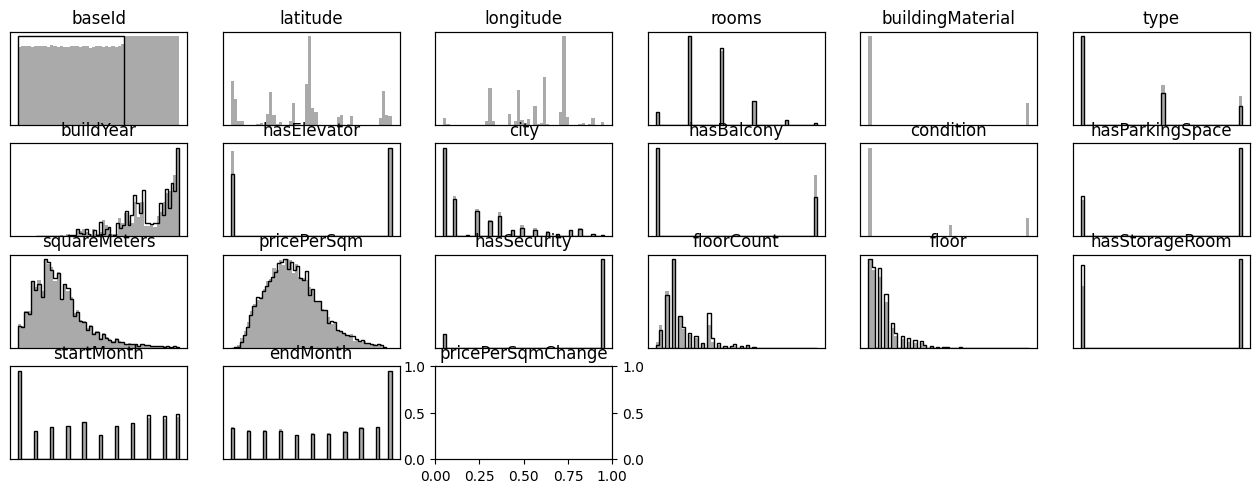

In [29]:
fig = plt.figure(figsize=(16, 7))

i=0
for col in guessData.columns:
  i += 1
  ax = fig.add_subplot(5,6,i)
  ax.set_title(col)
  ax2 = ax.twinx()
  if col in cleanData:
    ax2.hist(cleanData[col], histtype='step', bins=50, color='black')
  if col in guessData:
    ax.hist(guessData[col], bins=50, color="#aaa")
  ax.xaxis.set_visible(False)
  ax2.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax2.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

In [47]:
dataset = guessData
cityCounts = dataset.groupby('city').agg(
   Count=('city', 'count'),
   MedianPrice=('pricePerSqm', 'median')
).reset_index()
cityCounts = cityCounts.sort_values('Count', ascending=False)
cityCounts['MedianPrice'] = cityCounts['MedianPrice'].round(2)


endogenousDataset = dataset[['pricePerSqm', 'rooms', 'buildingMaterial', 'type', 'buildYear', 'hasElevator', 'hasBalcony', 'condition',
       'hasParkingSpace', 'squareMeters', 'hasSecurity',
       'floorCount', 'floor', 'hasStorageRoom']]
       
neighbourhoodDataset = dataset[['pricePerSqm', 'latitude', 'longitude']]

timeDataset = dataset[['pricePerSqm', 'startMonth', 'endMonth',
       'pricePerSqmChange']]

cityCounts

,city,Count,MedianPrice
13,warszawa,25861,17000.00
6,krakow,11850,15306.12
14,wroclaw,7866,12596.23
3,gdansk,7199,13408.82
7,lodz,4641,8194.44
4,gdynia,3149,11927.19
1,bydgoszcz,2533,7833.33
9,poznan,2491,11000.00
12,szczecin,1800,8929.16
8,lublin,1780,9442.18


In [51]:
if not os.path.exists('cleaned_datasets'):
    os.makedirs('cleaned_datasets')

majorCities = cityCounts[cityCounts['Count'] > 3000]['city'].tolist()
cityMapping = {
    'gdańsk': 'trojmiasto',
    'gdynia': 'trojmiasto'
}

dataset['mappedCity'] = dataset['city'].apply(lambda city: cityMapping.get(city.lower(), city.lower()))

for city in set([cityMapping.get(city.lower(), city.lower()) for city in majorCities]):
    cityMask = dataset['mappedCity'] == city
    
    endogenousCity = endogenousDataset[cityMask]
    neighbourhoodCity = neighbourhoodDataset[cityMask]
    timeCity = timeDataset[cityMask]
    
    endogenousCity.to_csv(f'cleaned_datasets/endogenous_{city}.csv', index=False)
    neighbourhoodCity.to_csv(f'cleaned_datasets/neighbourhood_{city}.csv', index=False)
    timeCity.to_csv(f'cleaned_datasets/time_{city}.csv', index=False)

endogenousDataset.to_csv('cleaned_datasets/endogenous_all.csv', index=False)
neighbourhoodDataset.to_csv('cleaned_datasets/neighbourhood_all.csv', index=False)
timeDataset.to_csv('cleaned_datasets/time_all.csv', index=False)